<a href="https://colab.research.google.com/github/Braafisch/Motion-Planning-Assignment/blob/main/Assignment_5/astar_exercise_without_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Search II Exercise Notebook

This notebook is given in the first graph search exercise course.

It first defines a lot of helper structures. Once these are defined, the exercise questions follow at the end.

## Imports and Constants

Start by importing the library used throughout the nodebook.

There is a high chance that you need to install at least one the following two packages, if you work locally on your laptop:
```
sudo apt install libcairo2-dev libjpeg-dev libgif-dev
pip3 install pycairo
```

If you use Google colab, then you likely need to run

```
!apt-get install libcairo2-dev libjpeg-dev libgif-dev
!pip install pycairo
```

**Important**: Do not continue, if you get an error with these imports. They need to be fixed first

In [2]:
!apt-get install libcairo2-dev libjpeg-dev libgif-dev
!pip install pycairo

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libjpeg-dev is already the newest version (8c-2ubuntu8).
libjpeg-dev set to manually installed.
libgif-dev is already the newest version (5.1.4-2ubuntu0.1).
libgif-dev set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libcairo-script-interpreter2 libpixman-1-dev libxcb-shm0-dev
Suggested packages:
  libcairo2-doc
The following NEW packages will be installed:
  libcairo-script-interpreter2 libcairo2-dev libpixman-1-dev libxcb-shm0-dev
0 upgraded, 4 newly installed, 0 to remove and 5 not upgraded.
Need to get 930 kB of archives.
After this operation, 3,986 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libcairo-script-interpreter2 amd64 1.15.10-2ubuntu0.1 [53.5 kB]
Get:2

In [3]:
import math
import io
import IPython.display
import cairo

Next define the following global constants used in the notebook.

In [4]:
T = True
F = False

# Some color constants. These are rgb values between 0 and 1
white = (1,1,1)
black = (0,0,0)
red = (0.91,0.3,0.24)
green = (0,0.63,0)
blue = (0,0.43,0.9)
orange = (1,0.5,0)
pink = (1,0.15,0.60)
yellow = (0.96,0.82,0.25)
gray = (0.5,0.5,0.5)

# Support Code

Next, some helper functions and classes are defined. You are not supposed to change these.

In [5]:
class Grid:
    """Stores a binary occupancy grid. True means
    that a cell is occupied and False means that it
    is free.
    
    Cells are identified as a pair of integers (x,y)
    where x is the column and y is the row of a cell.
    
    The free cells are used as nodes in a graph. 
    Multiple successor functions exist. For this reason,
    the successor functions are defined outside of the 
    grid class.
    """
    
    def __init__(self, data):
        self._data = data
        
        # Check whether data is valid.
        width = self.get_width()
        height = self.get_height()
        for y in range(height):
            assert len(data[y]) == width,\
                f"All rows in a grid must have the same width {width}. "+\
                "Row {y} is {len(data[y])} long."
            for x in range(width):
                assert data[y][x] == True or data[y][x] == False,\
                    "All cell elements must be True or False"
    
    def get_width(self):
        return len(self._data[0])
    
    def get_height(self):
        return len(self._data)
    
    def is_free(self, p):
        """Checks for a pair of x,y whether the cell is free.
        
        Cells outside of the grid are occupied by definition, i.e.,
        returns False for coordinates that are outside of the grid.
        """
        x,y = p
        if not x in range(self.get_width()):
            return False
        elif not y in range(self.get_height()):
            return False
        else:
            return not self._data[y][x]

    def get_free_cell_set(self):
        """Returns a list of all free cell coordinates"""
        return [
            (x,y)
            for x in range(self.get_width())
            for y in range(self.get_height())
            if self.is_free((x,y))
        ]

    def get_occupied_cell_set(self):
        """Returns a list of all occupied cell coordinates"""
        return [
            (x,y)
            for x in range(self.get_width())
            for y in range(self.get_height())
            if not self.is_free((x,y))
        ]

In [6]:
class PriorityQueue:
    """A minimum priority queue.
    
    The queue contains pairs of (key, element). Each pop operation
    removes the element with the smallest key from the queue.
    If two elements have the same key, then the elements are compared
    and the smaller element is popped first.
    
    The queue cannot contain the equal elements multiple time with
    varying keys.
    """
    
    def __init__(self, elements = None):
        if elements is not None:
            self._heap = elements
            self._pos = {
                element:i for i,(key, element) in enumerate(elements)
            }

            for i in range(len(elements)-1, -1, -1):
                self._sift_down(i)
        else:
            self._heap = []
            self._pos = {}
            
    def __len__(self):
        return len(self._heap)
    
    def __iter__(self):
        """Iterats over all (key,element) pairs in the queue in 
        an unspecified order"""
        return iter(self._heap)
    
    def __repr__(self):
        return f'PriorityQueue({self._heap})'
         
    def push_or_decrease_key(self, element, key):
        """Adds the pair (key, element) to the queue, if element is
        not yet part of the queue. Otherwise the key of element is set
        to the minimum of the already stored key or the key parameter"""
        if element not in self._pos:
            index = len(self)
            self._heap.append((key, element))
            self._pos[element] = index
            self._sift_up(index)
        else:
            index = self._pos[element]
            old_key, old_element = self._heap[index]
            assert element == old_element
            if key < old_key:
                self._heap[index] = (key, element)
                self._sift_up(index)
        
    def pop(self):
        """Removes the element with the minimum key from the queue
        and returns the element. If there are multiple elements with
        equal minimum keys, then the smallest element is returned first.
        
        pop can only be called if the queue is not empty"""
        assert len(self) != 0
        
        if len(self) == 1:
            _, result = self._heap[0]
            self._heap = []
            self._pos = {}
            return result
        else:
            assert len(self) > 1
            self._swap(0, len(self)-1)
            _, result = self._heap.pop()
            self._pos.pop(result)
            self._sift_down(0)
            return result
        
    def _swap(self, i, j):
        assert 0 <= i and i < len(self)
        assert 0 <= j and j < len(self)
        
        key_i, element_i = self._heap[i]
        key_j, element_j = self._heap[j]
        
        self._heap[i] = (key_j, element_j)
        self._heap[j] = (key_i, element_i)
        
        self._pos[element_i] = j
        self._pos[element_j] = i
        
    def _sift_up(self, node):
        while node != 0:
            assert 0 <= node and node < len(self)
            
            parent = (node-1) // 2 
            if self._heap[parent] < self._heap[node]:
                return
            else:
                self._swap(parent, node)
                node = parent
                
    def _sift_down(self, node):
        while True:
            assert 0 <= node and node < len(self)
            # Compute child indices 
            left_child = 2*node+1
            right_child = 2*node+2
            
            # Figure out what the smallest child is
            has_no_child = (left_child >= len(self))
            only_has_left_child = (right_child == len(self))
            has_both_children = (right_child < len(self))
            
            if has_no_child:
                return
            elif only_has_left_child:
                smallest_child = left_child
            else:
                assert has_both_children
                smallest_child = (
                    left_child 
                    if self._heap[left_child] < self._heap[right_child] 
                    else right_child
                )
            
            # Swap places with smallest child if necessary
            if self._heap[smallest_child] > self._heap[node]:
                return
            else:
                self._swap(smallest_child, node)
                node = smallest_child

In [7]:
def is_rect_free(grid, p1, p2):
    """Checks whether all cells in the rectanle defined by two
    coordinate pairs are free.
    """
    x1, y1 = p1
    x2, y2 = p2
    
    if x1 > x2:
        x1, x2 = x2, x1
    if y1 > y2:
        y1, y2 = y2, y1
    
    for x in range(x1, x2+1):
        for y in range(y1, y2+1):
            if not grid.is_free((x, y)):
                return False
    return True

def compute_knight_successor_list(grid, tail):
    """Weighted grid sucessor that can move like a chess king or knight"""
    s2 = math.sqrt(2)
    s5 = math.sqrt(5)
    delta_list = [
                   (-1, 2,s5),           ( 1, 2,s5),
        (-2, 1,s5),(-1, 1,s2),( 0, 1, 1),( 1, 1,s2),( 2, 1,s5),
                   (-1, 0, 1),           ( 1, 0, 1),
        (-2,-1,s5),(-1,-1,s2),( 0,-1, 1),( 1,-1,s2),( 2,-1,s5),
                   (-1,-2,s5),           ( 1,-2,s5)
    ]
    successor_list = []

    x,y = tail
    for dx,dy,weight in delta_list:
        head = (x+dx, y+dy)
        if is_rect_free(grid, tail, head):
            successor_list.append((weight, head))
    return successor_list

def knight_successor(grid):
    return lambda tail:compute_knight_successor_list(grid, tail)

In [8]:
direction_count = 8
E,NE,N,NW,W,SW,S,SE = range(direction_count)

def compute_directional_successor_list(grid, tail):
    """Weighted grid sucessor that can move like a chess king or knight"""
    s2 = math.sqrt(2)
    s5 = math.sqrt(5)
    delta_list = [
        [(2, -1, NE, s5),  (1, 0, E, 1),    (2, 1, SE, s5)], # from E
        [(1, -2, N, s5),  (1, -1, NE, s2), (2, -1, E, s5)], # from NE
        [(-1, -2, NW, s5), ( 0, -1, N, 1),  (1, -2, NE, s5)], # from N
        [(-1, -2, N, s5), (-1, -1, NW, s2),(-2, -1, W, s5)], # from NW
        [(-2, -1, NW, s5), (-1, 0, W, 1),   (-2, 1, SW, s5)], # from W
        [(-1, 2, S, s5),  (-1, 1, SW, s2), (-2, 1, W, s5)], # from SW
        [(-1, 2, SW, s5),  ( 0, 1, S, 1),   (1, 2, SE, s5)], # from S
        [(1, 2, S, s5),   (1, 1, SE, s2),  (2, 1, E, s5)] # from SE
    ]
    successor_list = []

    tail_x, tail_y, tail_dir = tail
    for dx, dy, head_dir, weight in delta_list[tail_dir]:
        head_x = tail_x + dx
        head_y = tail_y + dy
        head = (head_x, head_y, head_dir)
        if is_rect_free(grid, (tail_x, tail_y), (head_x, head_y)):
            successor_list.append((weight, head))
    return successor_list

def directional_successor(grid):
    return lambda tail:compute_directional_successor_list(grid, tail)

In [9]:
def show_mini_grid(grid, node_color = None, pngfile = None, svgfile = None, pdffile = None):
    # Use {} as default value. See
    # https://dollardhingra.com/blog/python-mutable-default-arguments/
    # for details
    if node_color is None:
        node_color = {}
   
    # Fill occupied cells with black color if nothing else
    # is requested.
    for p in grid.get_occupied_cell_set():
        if p not in node_color:
            node_color[p] = (0,0,0)

    # Setup some constants and figure out the canvas size
    grid_width = grid.get_width()
    grid_height = grid.get_height()
    cell_pixel_width = 5
    canvas_width = grid_width*cell_pixel_width
    canvas_height = grid_height*cell_pixel_width
    
    # Function that does the actual drawing
    def draw(surface):
        context = cairo.Context(surface)

        context.set_source_rgb(1,1,1)
        context.rectangle(0, 0, canvas_width, canvas_height)
        context.fill()
        
        for x in range(grid_width):
            for y in range(grid_height):
                r,g,b = node_color.get((x,y), (1,1,1))

                rect_x = x*cell_pixel_width
                rect_y = y*cell_pixel_width
                
                context.set_source_rgb(r,g,b)
                context.rectangle(rect_x, rect_y, cell_pixel_width, cell_pixel_width)
                context.fill()
    
    # Setup a cairo surface that writes to an in-memory file
    svg_buffer = io.BytesIO()
    surface = cairo.SVGSurface(svg_buffer, canvas_width, canvas_height)
    draw(surface)
    if pngfile is not None:
        surface.write_to_png(pngfile)
    surface = None
            
    svg_data = svg_buffer.getvalue()
    if svgfile is not None:
        with open(svgfile, 'wb') as out:
            out.write(svg_data)
            
    if pdffile is not None:
        pdf_buffer = io.BytesIO()
        surface = cairo.PDFSurface(pdf_buffer, canvas_width, canvas_height)
        draw(surface)
        surface = None
        with open(pdffile, 'wb') as out:
            out.write(pdf_buffer.getvalue())
            
    return IPython.display.SVG(data=svg_data)

In [10]:
the_grid = Grid([
  [F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,F],
  [F,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T],
  [T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T],
  [T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T],
  [T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T],
  [T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T],
  [T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T],
  [T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T],
  [T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T],
  [T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T],
  [T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F],
  [T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F],
  [T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F],
  [T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F],
  [T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F],
  [T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F],
  [F,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F],
  [F,F,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F],
  [F,F,F,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F],
  [F,F,F,T,T,T,T,T,T,T,T,T,F,F,F,F,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F],
  [F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F],
  [F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T],
  [F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T],
  [F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T],
  [F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T],
  [F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,F,F,F,F,T,T,T,T,T,T,T],
  [T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T],
  [T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T],
  [T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T],
  [T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T],
  [T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,T,T],
  [T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F],
  [T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F],
  [F,F,F,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F],
  [F,F,F,F,F,F,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,F,F,F,F,F,F,F,F,F],
  [F,F,F,F,F,F,F,F,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F],
  [F,F,F,F,F,F,F,F,F,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F],
  [F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F],
  [F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F],
  [F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F],
  [F,F,F,F,F,F,F,F,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F],
  [F,F,F,F,F,F,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F],
  [F,F,F,F,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F],
  [F,F,F,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F],
  [F,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F],
  [F,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F],
  [T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F],
  [T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F],
  [T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F],
  [F,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F],
  [F,F,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F],
  [F,F,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F],
  [F,F,F,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F],
  [F,F,F,F,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F],
  [F,F,F,F,F,F,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F],
  [F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F],
  [F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T],
  [F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T],
  [F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T],
  [F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T],
  [F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T],
  [F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T],
  [F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T],
  [F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T],
  [F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T],
  [F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T],
  [F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F],
  [F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F],
  [F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F],
  [F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F],
  [F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F],
  [F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F],
  [F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F],
  [F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F],
  [F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F],
  [F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F],
  [F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T],
  [F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T],
  [F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T],
  [F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T],
  [F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T],
  [F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T],
  [F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T],
  [F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,F],
  [F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,F,F,F],
  [F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,F,F,F,F],
  [F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,T,T,T,T,T,T,T,F,F,F,F,F,F],
  [F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F],
  [F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F],
  [F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F],
  [F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F],
  [F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F],
  [F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F],
  [F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F],
  [F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F],
  [F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,T,T,T,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,T,T,T,T,T,T,T,T],
  [F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T],
  [F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T],
  [F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T],
  [F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F]
])

In [11]:
the_source = (50,18)
the_target = (25,75)

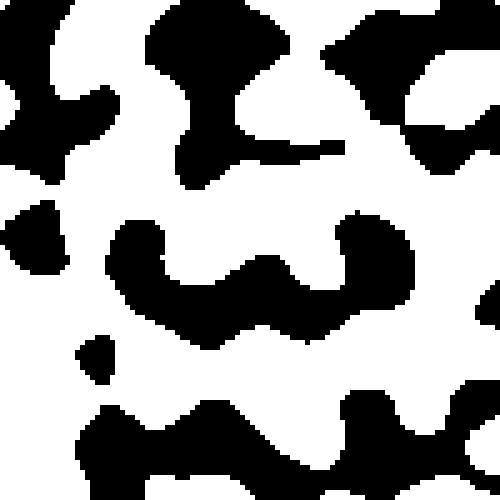

In [12]:
show_mini_grid(the_grid)

# Exercises

## Exercise 1: Implement Dijkstra's Algorithm

**Hint**: Most of the code is given in the lecture slides.

In [17]:
def unpack_path(back, now):
  path = [now]
  while back[now] != now:
    now = back[now]
    path.append(now)
  path.reverse()
  return path

In [19]:
def dij_algo(successor, source, target):
    """Finds a shortest path. 
    
    successor is a function that maps a node onto a list of 
    (weight, node)-pairs. The node is a successor and the
    weight is the corresponding edge's weight.
    
    The shortests path should go from source to target.
    
    Returns a triple (length, path, popped_nodes) where
    
    length is the shortest path length.
    path is a list of nodes in a shortest path.
    popped_nodes is the list of nodes removed from the queue.
    
    If there is no path then length and path should be none"""
    # Implement me
    back = {source:source}
    dist = {source:0}
    queue = PriorityQueue()
    queue.push_or_decrease_key(source, 0)

    while queue:
      tail = queue.pop()
      if tail == target:
        return dist[target], unpack_path(back, target) 
      for weight, head in successor(tail):
        dist_to_head = dist[tail]+weight
        if head not in dist or dist_to_head < dist[head]:
          dist[head] = dist_to_head
          back[head] = tail
          queue.push_or_decrease_key(head, dist_to_head)
    return None, None

In [20]:
successor = knight_successor(the_grid)
assert abs(dij_algo(successor, the_source, the_target)[0]-107.4) < 0.5
assert abs(dij_algo(successor, (20, 10), (50, 18))[0]-92.2) < 0.5
assert dij_algo(successor, (50, 40), (50, 40))[0] == 0
assert dij_algo(successor, (20, 10), (90, 18))[0] == None

## Exercise 2: Visualize Dijkstra's Algorithm

Write code to display the grid and color all popped nodes and the shortest path found.

In [ ]:
_, path, popped_nodes = dij_algo(knight_successor(the_grid), the_source, the_target)

node_color = {}

# Implement code to color the cells

show_mini_grid(the_grid, node_color)

## Exercise 3: Implement A* with straight line heuristic

In [21]:
def straight_line_heuristic(target):
    target_x, target_y = target
    def the_heuristic(node):
        node_x, node_y = node
        return math.hypot(target_x-node_x, target_y-node_y)
    return the_heuristic

In [23]:
def astar_algo(successor, heuristic, source, target):
    """Finds a shortest path.
    
    Has nearly the same interface as dij_algo. See dij_algo for
    a detailed description of the parameters.
    
    heuristic is a function that maps every node onto
    a consistent lower bound to the target-
    """
    # Implement me
    back = {source:source}
    dist = {source:0}
    queue = PriorityQueue()
    queue.push_or_decrease_key(source, 0)

    while queue:
      tail = queue.pop()
      if tail == target:
        return dist[target], unpack_path(back, target) 
      for weight, head in successor(tail):
        dist_to_head = dist[tail]+weight
        if head not in dist or dist_to_head < dist[head]:
          dist[head] = dist_to_head
          back[head] = tail
          queue.push_or_decrease_key(head, dist_to_head)
    return None, None

In [24]:
dist, path, popped = astar_algo(
    knight_successor(the_grid), 
    straight_line_heuristic(the_target), 
    the_source, the_target)
print(dist, the_source)
show_mini_grid(
    the_grid,
    node_color = {
        node:red for node in popped
    }
)

TypeError: ignored

In [ ]:
successor = knight_successor(the_grid)
assert abs(astar_algo(successor, straight_line_heuristic(the_target), the_source, the_target)[0]-107.4) < 0.5
assert abs(astar_algo(successor, straight_line_heuristic((50, 18)), (20, 10), (50, 18))[0]-92.2) < 0.5
assert astar_algo(successor, straight_line_heuristic((50, 40)), (50, 40), (50, 40))[0] == 0
assert astar_algo(successor, straight_line_heuristic((90, 18)), (20, 10), (90, 18))[0] == None

## Exercise 4: Visually compare the nodes explored by Dijkstra and by A*

In [ ]:
dij_dist, dij_path, dij_popped_nodes = dij_algo(
    successor = knight_successor(the_grid), 
    source = the_source, 
    target = the_target
)
astar_dist, astar_path, astar_popped_nodes = astar_algo(
    successor = knight_successor(the_grid), 
    heuristic = straight_line_heuristic(the_target),
    source = the_source, 
    target = the_target
)

assert abs(dij_dist - astar_dist) < 0.5

node_color = {}

# Implement code to color the cells

show_mini_grid(the_grid, node_color)

## Exercise 5: Implement a straight line heuristic that works with the directional motion model

In [ ]:
def directional_straight_line_heuristic(target):
    # Implement me
    pass

In [ ]:
successor = directional_successor(the_grid)
dir_source = the_source + (SE,)
dir_target = the_target + (N,)

assert abs(astar_algo(successor, directional_straight_line_heuristic(dir_target), dir_source, dir_target)[0]-119.1) < 0.5

## Exercise 6: Visualize shortest directional path and A* popped nodes

In [ ]:
successor = directional_successor(the_grid)
dir_source = the_source + (SE,)
dir_target = the_target + (N,)
heuristic = directional_straight_line_heuristic(dir_target)
_, path, popped_nodes = astar_algo(successor, heuristic, dir_source, dir_target)

# Implement here